# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Data Description](#Data-Description)
2. [New Data Format](#New-Data-Format)
3. [Problem Baseline](#Problem:-Es gibt-keine-Baseline)
4. [Load Data](#Load-Data)
5. [Pupil Data](#Pupil-Data)
6. [Blink Data](#Blink-Data)
7. [Gaze Data](#Gaze-Data)


# Data Description
The original dataset was in a Matlab format. The data was converted to CSV format for easier handling. The self-developed Matlab-Export--Scripts are in the folder [Matlab-Export-Scripts](./MatlabExport).

- The Data are recorded with 240Hz
- The NASA TLX Scores are recorded after each task

The Description of the original data is in the file [Data Description](./readme.txt)

# New Data Format

The new data structure is as follows:
- Participants.csv: Contains the participant information with some demographic data and a unique participant ID.
- Participant_X
    - Test1: 5 Images, no time constraint, no secondary task.
        - Participant_X_Annotations_1.csv: Contains the annotations for the test.
        - Participant_X_Blinks_1.csv: Contains the blinks data for the test.
        - Participant_X_Gaze_1.csv: Contains the gaze data for the test.
        - Participant_X_Pupil_1.csv: Contains the pupil data for the test.
    - Test2: 5 images, with time constraint, no secondary task.
    - Test3: 5 images, with time constraint, with secondary task.
    - Test4: 5 images, no time constraint, with secondary task.

# Problem: Es gibt keine Baseline 
Lösung: 
- Option1: eine BaseLine über alle Tests eines Teilnehmers erstellen
- Option2: eine BaseLine über den einfachsten Test erstellen, da hier die größte Entspannung erwartet wird 
- Option3: keine BaseLine verwenden

Wenn es einen einfachen Test gibt, dann ist Option2 die beste Wahl. Ansonsten ist Option1 die beste Wahl.

# Vorgehen:
- "Sauberen" Feature Datensatz erstellen
- "Sauberen" Timeseries Datensatz erstellen
- 47 Teilnehmer sind zu wenig, daher ein generatives Modell (CNN?) verwenden, um künstliche Daten zu generieren
- dann Features extrahieren: Blinkrate, Fixationsrate, Pupillendurchmesser, NASA-TLX Scores, (Testdauer), (Alter), (Geschlecht), (Education)
- Prediction Modell trainieren mit den artificial data --> Baseline Modell
- (Model tuning)
- Finales Modell


Dataset Layout:
- participant_id
- test_id
- test_duration
- mental
- physical
- temporal
- performance
- effort
- frustration
- mean
- blinkrate (pro Sekunde)
- fixationrate (pro Sekunde)
- mean_pupil_diameter
- median_pupil_diameter

Dataset Layout V2 extends the original dataset with the following features:
- blinkrate_rel (relative change to baseline)
- blinkrate_rel_pct (relative change to baseline in percent)
- fixationrate_rel
- fixationrate_rel_pct
- mean_pupil_diameter_rel
- mean_pupil_diameter_rel_pct
- median_pupil_diameter_rel
- median_pupil_diameter_rel_pct


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Load Data

In [5]:
import os

data_path1 = '../Data/'
data_path2 = '../data/'

# Check which path exists
if os.path.exists(data_path1):
    data_path = data_path1
elif os.path.exists(data_path2):
    data_path = data_path2
else:
    raise FileNotFoundError("Neither data_path1 nor data_path2 exists")

# Load data
participant_list = pd.read_csv(data_path + 'participants.csv')
print(participant_list.head())

   ID  VisualAcuity_logMAR_ Gender  Age  Education
0   1                 -0.04      F   28         18
1   2                 -0.10      F   28         18
2   3                 -0.08      F   38         16
3   4                 -0.07      F   29         18
4   5                 -0.15      M   30         18


In [6]:

# initiate an array to store the data
# 47 rows = 74 participants,
# 1. column = Participant ID
# 2.-5. columns = 4 tests

# each test: 
# 1. mental rating
# 2. physical rating
# 3. temporal rating
# 4. performance rating
# 5. effort rating
# 6. frustration rating
# 7. mean rating
# 8. values blinks
# 9. values gaze
# 10. values pupil

# 4 columns = 4 tests
participant_tests = np.zeros((participant_list.shape[0], 5), dtype=object)


# iterate over all participants and tests
for participant_number in range(1, participant_list.shape[0]+1):
    for test_number in range(1, 5):
        path_to_participant = data_path + 'Participant_' + str(participant_number) 
        path_to_test = path_to_participant + '/Test' + str(test_number) + '/'
        path_to_annotations = path_to_test + 'Participant_' + str(participant_number) + '_Annotations_' + str(test_number) + '.csv'
        path_to_blinks = path_to_test + 'Participant_' + str(participant_number) + '_Blinks_' + str(test_number) + '.csv'
        path_to_gaze = path_to_test + 'Participant_' + str(participant_number) + '_Gaze_' + str(test_number) + '.csv'
        path_to_pupil = path_to_test + 'Participant_' + str(participant_number) + '_Pupil_' + str(test_number) + '.csv'
        
        # change the column names of the NASA TLX values in all participants and all tests, so there is no number in the column name
        annotations = pd.read_csv(path_to_annotations)
        annotations.columns = ['mental', 'physical', 'temporal', 'performance', 'effort', 'frustration', 'mean']

        participant_tests[participant_number-1][test_number-1] = \
            [participant_number,
            annotations, 
            [pd.read_csv(path_to_blinks)], 
            [pd.read_csv(path_to_gaze)], 
            [pd.read_csv(path_to_pupil)]]


print(participant_tests.shape)
print(participant_tests[:1])


(47, 5)
[[list([1,    mental  physical  temporal  performance  effort  frustration  mean
  0      10         5        15           25      25           10    15, [   id  start_timestamp  duration  end_timestamp  start_frame_index  index  \
  0   1      5437.625617  0.236131    5437.861748                 37     40
  1   2      5444.161561  0.180073    5444.341634                231    233

     end_frame_index  confidence  \
  0               44    0.703872
  1              236    0.553669

                                       filter_response  \
  0  0.5068225043614704 0.5512669488059149 0.595711...
  1  0.5048782729116744 0.5493227173561188 0.592878...

                                             base_data
  0  5437.625617 5437.629564 5437.633621 5437.63786...
  1  5444.161561 5444.165642 5444.169793 5444.17554...  ], [      gaze_timestamp  world_index  confidence  norm_pos_x  norm_pos_y  \
  0        5410.551715            0    0.999499    0.446264    0.846886
  1        5410.5558

In [7]:
print(participant_tests.shape)
print(participant_tests[0].shape)

(47, 5)
(5,)


In [8]:
partcipant_1_test_1 = participant_tests[0][0]
print("Participant ID: " + str(partcipant_1_test_1[0]))
print("Participant NASA TLX Values: " + str(partcipant_1_test_1[1]))
print("Blink Werte: " + str(partcipant_1_test_1[2]))
print("Gaze Werte: " + str(partcipant_1_test_1[3]))
print("Pupil Werte: " + str(partcipant_1_test_1[4]))


Participant ID: 1
Participant NASA TLX Values:    mental  physical  temporal  performance  effort  frustration  mean
0      10         5        15           25      25           10    15
Blink Werte: [   id  start_timestamp  duration  end_timestamp  start_frame_index  index  \
0   1      5437.625617  0.236131    5437.861748                 37     40   
1   2      5444.161561  0.180073    5444.341634                231    233   

   end_frame_index  confidence  \
0               44    0.703872   
1              236    0.553669   

                                     filter_response  \
0  0.5068225043614704 0.5512669488059149 0.595711...   
1  0.5048782729116744 0.5493227173561188 0.592878...   

                                           base_data  
0  5437.625617 5437.629564 5437.633621 5437.63786...  
1  5444.161561 5444.165642 5444.169793 5444.17554...  ]
Gaze Werte: [      gaze_timestamp  world_index  confidence  norm_pos_x  norm_pos_y  \
0        5410.551715            0    0.9994

In [9]:
# generate a new pandas dataframe with data from all participants and all tests
# the columns are: participant_id, test_id, test_duration, mental, physical, temporal, performance, effort, frustration, mean, blinks, gaze, pupil
# blinks, gaze and pupil will be filled in the next steps

# initiate the dataframe

preprocessed_df = pd.DataFrame(columns=['participant_id', 'test_id', 'test_duration', 'mental', 'physical', 'temporal', 'performance', 'effort', 'frustration', 'mean'])

# fill the dataframe with the data from the participants
for n in range(len(participant_tests)):
    participant_n = participant_tests[n]
    participant_id = participant_n[0][0]
    # iterate over all tests of the participant
    for test_iterator in range(len(participant_n)-1):
        # test id is the index of the test in the participant array
        test_id = test_iterator + 1
        test = participant_n[test_iterator]
        # placeholder test duration
        test_duration = 0
        # get the NASA TLX values
        nasa_tlx_values = test[1]
        mental = nasa_tlx_values['mental'][0]
        physical = nasa_tlx_values['physical'][0]
        temporal = nasa_tlx_values['temporal'][0]
        performance = nasa_tlx_values['performance'][0]
        effort = nasa_tlx_values['effort'][0]
        frustration = nasa_tlx_values['frustration'][0]
        mean = nasa_tlx_values['mean'][0]
        # add the data to the dataframe
        new_row_df = pd.DataFrame([{'participant_id': participant_id, 'test_id': test_id, 'test_duration': test_duration, 'mental': mental, 'physical': physical, 'temporal': temporal, 'performance': performance, 'effort': effort, 'frustration': frustration, 'mean': mean}])
        
        preprocessed_df = pd.concat([preprocessed_df, new_row_df], ignore_index=True)
        
  
print(preprocessed_df.head())

  participant_id test_id test_duration mental physical temporal performance  \
0              1       1             0     10        5       15          25   
1              1       2             0     50       30       25          50   
2              1       3             0    100       10       75          80   
3              1       4             0     60       15       45          50   
4              2       1             0     20       10       20          10   

  effort frustration  mean  
0     25          10    15  
1     15          25  32.5  
2     90          20  62.5  
3     20          25  35.8  
4     20          15  15.8  


# Pupil Data
Only use diameter with a high confidence level. <br>
A dialted pupil can be a sign of cognitive load -> <br>
Romano Bergstrom, Jennifer (2014). Eye Tracking in User Experience Design || Physiological Response Measurements., 81–108. <br> 
doi:10.1016/b978-0-12-408138-3.00004-2  

In [10]:
# iterate through all participants and tests
for current_participant in range(len(participant_tests)):
    for i in range(4):
        participant_test = participant_tests[current_participant][i]
        participant_test_pupil = participant_test[4][0]
        # filter the pupil values, so only rows with a confidence level of 0.8 are included
        # if there is a row with the same timestamp, use the one with the higher confidence level
        # save only the columns timestamp, confidence, and diameter and method
        participant_test_pupil_filtered = participant_test_pupil[participant_test_pupil['confidence'] > 0.8]
        participant_test_pupil_filtered = participant_test_pupil_filtered.sort_values('confidence', ascending=False).drop_duplicates('pupil_timestamp').sort_index()
        participant_test_pupil_filtered = participant_test_pupil_filtered[['pupil_timestamp', 'confidence', 'diameter', 'method']]
        # normalize the time, so for each test the time starts at 0
        participant_test_pupil_filtered['pupil_timestamp'] = participant_test_pupil_filtered['pupil_timestamp'] - participant_test_pupil_filtered['pupil_timestamp'].iloc[0]
        participant_tests[current_participant][i][4][0] = participant_test_pupil_filtered


# add the pupil data to the preprocessed dataframe where the participant_id and test_id match, into the column 'pupil'
for n in range(len(participant_tests)):
    participant_n = participant_tests[n]
    participant_id = participant_n[0][0]
    for test_iterator in range(len(participant_n)-1):
        test_id = test_iterator + 1
        test = participant_n[test_iterator]
        test_pupil = test[4][0]
        
        # mean and median pupil diameter for each test
        mean_pupil_diameter = test_pupil['diameter'].mean()
        median_pupil_diameter = test_pupil['diameter'].median()
        
        new_df = pd.DataFrame(test_pupil, columns=['pupil_timestamp', 'diameter']).reset_index(drop=True)
        
        location = (preprocessed_df['participant_id'] == participant_id) & (preprocessed_df['test_id'] == test_id)
        # get the index of the location
        location = preprocessed_df.index[location].tolist()[0]
        
        # add the data to the dataframe
       # preprocessed_df.at[location, 'pupil'] = new_df
        preprocessed_df.at[location, 'mean_pupil_diameter'] = mean_pupil_diameter
        preprocessed_df.at[location, 'median_pupil_diameter'] = median_pupil_diameter
        
        test_duration = test_pupil['pupil_timestamp'].iloc[-1]
        preprocessed_df.at[location, 'test_duration'] = test_duration
        
# get the first participant and the first test and show the pupil data of preprocessed_df
#print(preprocessed_df.loc[0, 'pupil'])
print(preprocessed_df.loc[0, 'test_duration'])

print(preprocessed_df['mean_pupil_diameter'].describe())
print(preprocessed_df['median_pupil_diameter'].describe())



33.643950000000586
count    188.000000
mean      34.841518
std        5.269522
min       25.644326
25%       31.054235
50%       33.783967
75%       37.903275
max       50.119098
Name: mean_pupil_diameter, dtype: float64
count    188.000000
mean      34.738427
std        5.195801
min       25.583751
25%       31.085921
50%       33.724105
75%       37.631562
max       50.139223
Name: median_pupil_diameter, dtype: float64


In [11]:
current_participant = 1

# print each NASA TLX value for each test
for i in range(4):
    participant_test = participant_tests[current_participant][i]
    print(str(participant_test[1]))

   mental  physical  temporal  performance  effort  frustration  mean
0      20        10        20           10      20           15  15.8
   mental  physical  temporal  performance  effort  frustration  mean
0      50        10        60           30      30           25  34.2
   mental  physical  temporal  performance  effort  frustration  mean
0      50        10        20           25      50           20  29.2
   mental  physical  temporal  performance  effort  frustration  mean
0      85        10        90           90      80           85  73.3


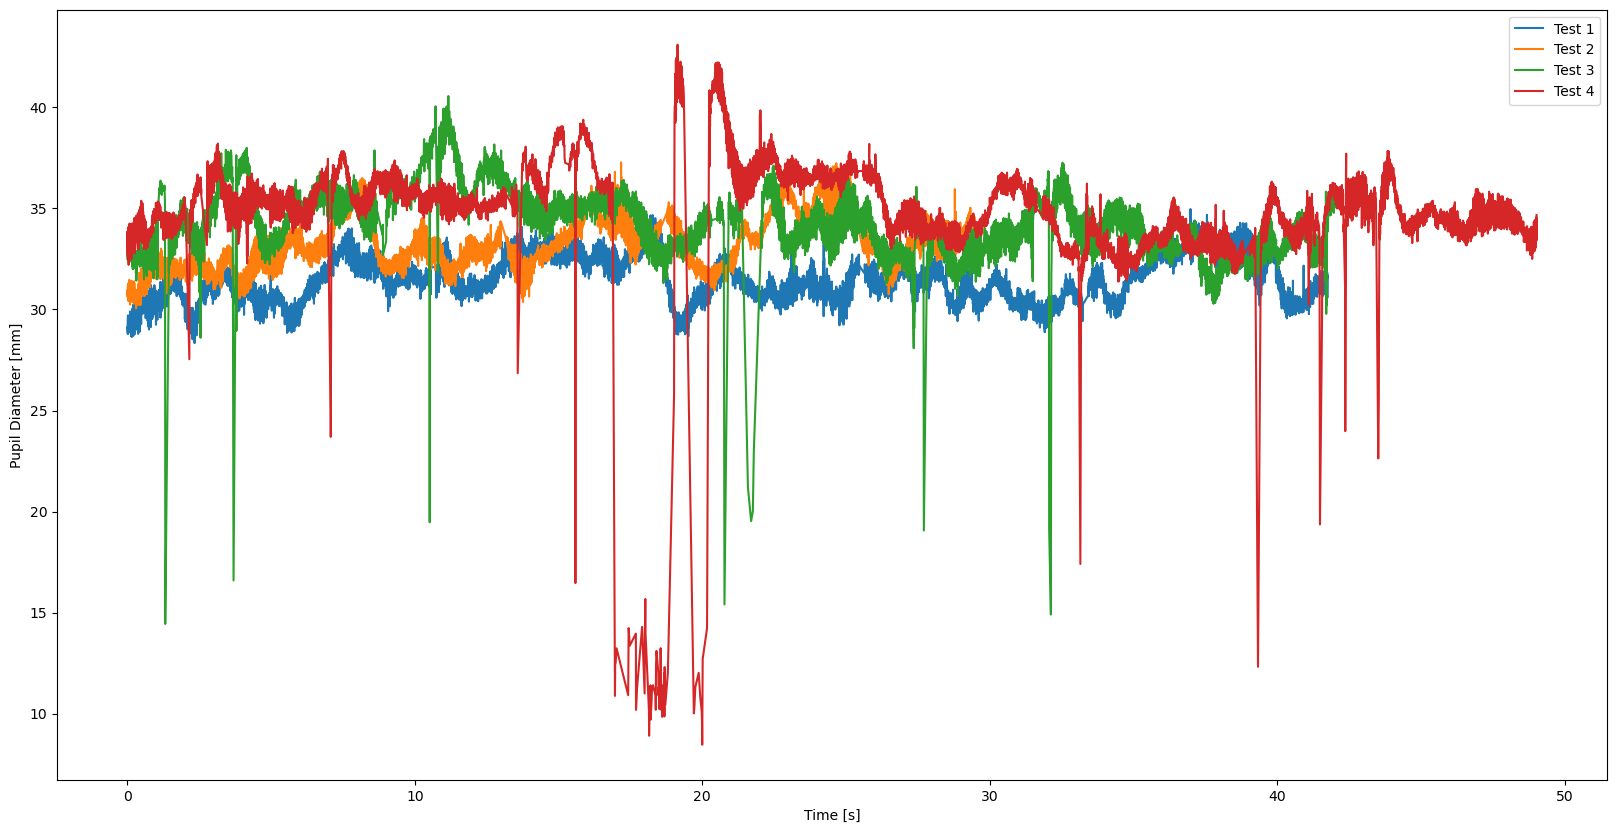

In [12]:
# plot the pupil diameter over time for all tests in one plot in different colors
plt.figure(figsize=(20, 10))
for i in range(4):
    participant_test = participant_tests[current_participant][i]
    plt.plot(participant_test[4][0]['pupil_timestamp'], participant_test[4][0]['diameter'], label='Test ' + str(i+1))
plt.xlabel('Time [s]')
plt.ylabel('Pupil Diameter [mm]')
plt.legend()
plt.show()

# Blink Data
Higher blink rate can be a sign of cognitive load -> <br>
Combining cognitive and visual distraction: Less than the sum of its parts
Yulan Liang, John D. Lee, 2010
doi:10.1016/j.aap.2009.05.001

at least in tasks with visual tasks -> 
Mental Workload and Visual Impairment: Differences between Pupil, Blink, and Subjective Rating <br>
Miguel Ángel Recarte, Elisa Pérez, Ángela Conchillo and Luis Miguel Nunes 
doi:10.1017/S1138741600004406 

In [13]:
print(str((participant_tests)))

[[list([1,    mental  physical  temporal  performance  effort  frustration  mean
  0      10         5        15           25      25           10    15, [   id  start_timestamp  duration  end_timestamp  start_frame_index  index  \
  0   1      5437.625617  0.236131    5437.861748                 37     40
  1   2      5444.161561  0.180073    5444.341634                231    233

     end_frame_index  confidence  \
  0               44    0.703872
  1              236    0.553669

                                       filter_response  \
  0  0.5068225043614704 0.5512669488059149 0.595711...
  1  0.5048782729116744 0.5493227173561188 0.592878...

                                             base_data
  0  5437.625617 5437.629564 5437.633621 5437.63786...
  1  5444.161561 5444.165642 5444.169793 5444.17554...  ], [      gaze_timestamp  world_index  confidence  norm_pos_x  norm_pos_y  \
  0        5410.551715            0    0.999499    0.446264    0.846886
  1        5410.555834      

In [14]:
for n in range(len(participant_tests)):
    participant_n = participant_tests[n]
    participant_id = participant_n[0][0]
    for test_iterator in range(len(participant_n)-1):
        test_id = test_iterator + 1
        test = participant_n[test_iterator]
        
        # only use the columns start_timestamp and end_timestamp, duration and confidence   
        participant_test_blinks = test[2][0] # extract
        participant_test_blinks_filtered = participant_test_blinks[['start_timestamp', 'end_timestamp', 'duration', 'confidence']] # filter
    
        # normalize the time, so for each test the time starts at 0
        # check if data is not empty
        if participant_test_blinks_filtered.shape[0] > 0:
            participant_test_blinks_filtered.loc[:, 'start_timestamp'] = participant_test_blinks_filtered['start_timestamp'] - participant_test_blinks_filtered['start_timestamp'].iloc[0]
            participant_test_blinks_filtered.loc[:, 'end_timestamp'] = participant_test_blinks_filtered['end_timestamp'] - participant_test_blinks_filtered['end_timestamp'].iloc[0]
            participant_tests[current_participant][test_iterator][2][0] = participant_test_blinks_filtered
    
            # calculate the blink rate for each test. the unit of the timestamp is seconds
            duration = preprocessed_df.loc[(preprocessed_df['participant_id'] == participant_id) & (preprocessed_df['test_id'] == test_id), 'test_duration']
            print("Participant ID: " + str(participant_id) + " Test ID: " + str(test_id))
            print("Duration: " + str(duration.values[0]))
            print("blink Count: " + str(participant_test_blinks_filtered.shape[0]))
            
            blink_rate = participant_test_blinks_filtered.shape[0] / duration.values[0]
            print("Blink Rate: " + str(blink_rate) + " blinks/s")
            
            loc_in_df = (preprocessed_df['participant_id'] == participant_id) & (preprocessed_df['test_id'] == test_id)
            location = preprocessed_df.index[loc_in_df].tolist()[0]
            preprocessed_df.at[location, 'blinkrate'] = blink_rate


Participant ID: 1 Test ID: 1
Duration: 33.643950000000586
blink Count: 2
Blink Rate: 0.05944605196476529 blinks/s
Participant ID: 1 Test ID: 3
Duration: 71.42382300000008
blink Count: 14
Blink Rate: 0.19601303055424496 blinks/s
Participant ID: 1 Test ID: 4
Duration: 38.16344200000003
blink Count: 2
Blink Rate: 0.052406174474514074 blinks/s
Participant ID: 2 Test ID: 1
Duration: 41.74804700000095
blink Count: 2
Blink Rate: 0.047906432605097776 blinks/s
Participant ID: 2 Test ID: 3
Duration: 42.02767599999788
blink Count: 14
Blink Rate: 0.3331138271837992 blinks/s
Participant ID: 2 Test ID: 4
Duration: 49.023875999992015
blink Count: 2
Blink Rate: 0.0407964478369749 blinks/s
Participant ID: 3 Test ID: 1
Duration: 42.35030099999858
blink Count: 6
Blink Rate: 0.14167549836305063 blinks/s
Participant ID: 3 Test ID: 2
Duration: 45.0635059999986
blink Count: 4
Blink Rate: 0.08876362172086931 blinks/s
Participant ID: 3 Test ID: 3
Duration: 86.71307800000068
blink Count: 18
Blink Rate: 0.207581

In [15]:
print(preprocessed_df.head())

  participant_id test_id test_duration mental physical temporal performance  \
0              1       1      33.64395     10        5       15          25   
1              1       2     28.484322     50       30       25          50   
2              1       3     71.423823    100       10       75          80   
3              1       4     38.163442     60       15       45          50   
4              2       1     41.748047     20       10       20          10   

  effort frustration  mean  mean_pupil_diameter  median_pupil_diameter  \
0     25          10    15            43.855534              43.893976   
1     15          25  32.5            42.935538              43.021599   
2     90          20  62.5            44.704459              44.791630   
3     20          25  35.8            45.762156              45.845470   
4     20          15  15.8            31.492393              31.393101   

   blinkrate  
0   0.059446  
1        NaN  
2   0.196013  
3   0.052406  
4   0

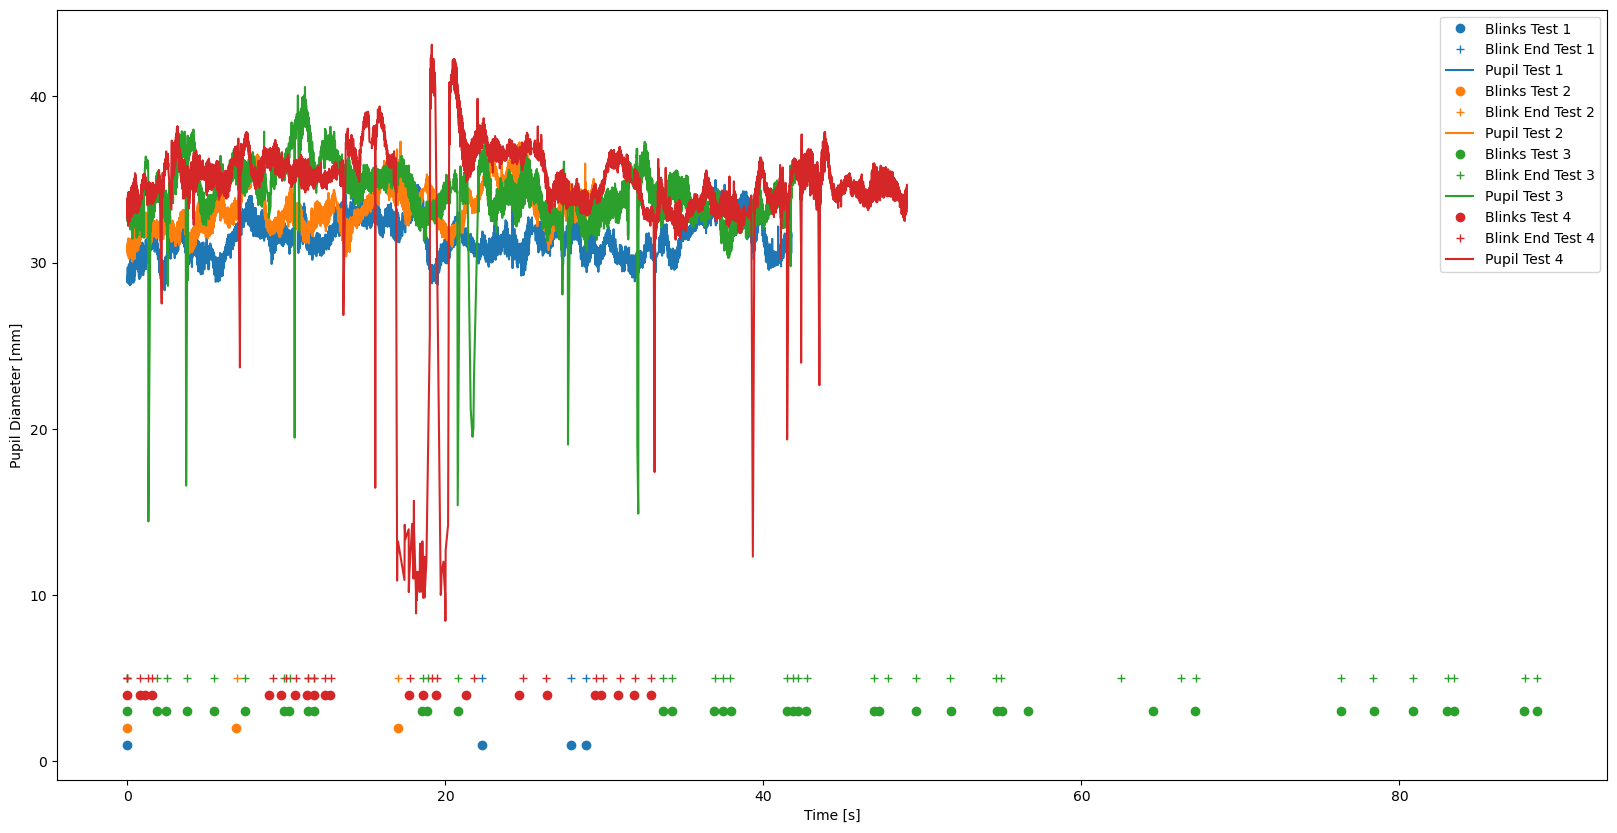

In [16]:
# plot the blink rate over time for all tests in one plot in different colors together with the pupil diameter. the color for all test 1 is red, for all test 2 is green, for all test 3 is blue, and for all test 4 is yellow. show the end of a blink with a cross
plt.figure(figsize=(20, 10))
for i in range(4):
    participant_test = participant_tests[current_participant][i]
    participant_test_blinks = participant_test[2][0]
    participant_test_pupil = participant_test[4][0]
    if participant_test_blinks.shape[0] > 0:
        plt.plot(participant_test_blinks['start_timestamp'], np.ones(participant_test_blinks.shape[0])*(i+1), 'o', color='C' + str(i), label='Blinks Test ' + str(i+1))
        plt.plot(participant_test_blinks['end_timestamp'], np.ones(participant_test_blinks.shape[0])*5, '+', color='C'+str(i), label='Blink End Test ' + str(i+1))
        
    plt.plot(participant_test_pupil['pupil_timestamp'], participant_test_pupil['diameter'], label='Pupil Test ' + str(i+1))
plt.xlabel('Time [s]')
plt.ylabel('Pupil Diameter [mm]')
plt.legend()
plt.show()


# Gaze Data
Fixations are calculated through PeyeMMV: Python implementation of EyeMMV’s fixation detection algorithm <br> 
https://github.com/krasvas/PeyeMMV <br> 
which is based on EyeMMV toolbox: An eye movement post-analysis tool based on a two-step spatial dispersion threshold for fixation identification <br>
https://bop.unibe.ch/JEMR/article/view/2370 <br>



In [17]:
for n in range(len(participant_tests)):
    participant_n = participant_tests[n]
    participant_id = participant_n[0][0]
    for test_iterator in range(len(participant_n)-1):
        test_id = test_iterator + 1
        test = participant_n[test_iterator]
        
        # only use the columns gaze_timestamp, confidence, norm_pos_x, norm_pos_y
        participant_test_gaze = test[3][0]
        # only values with a confidence level of 0.5 are included
        participant_test_gaze_filtered = participant_test_gaze[participant_test_gaze['confidence'] > 0.5]
        # remove x or y values that are smaller than 0 or bigger than 1
        participant_test_gaze_filtered = participant_test_gaze_filtered[(participant_test_gaze_filtered['norm_pos_x'] >= 0) & (participant_test_gaze_filtered['norm_pos_x'] <= 1) & (participant_test_gaze_filtered['norm_pos_y'] >= 0) & (participant_test_gaze_filtered['norm_pos_y'] <= 1)]
        # normalize the time, so for each test the time starts at 0
        participant_test_gaze_filtered.loc[:, 'gaze_timestamp'] = participant_test_gaze_filtered['gaze_timestamp'] - participant_test_gaze_filtered['gaze_timestamp'].iloc[0]
        participant_tests[n][test_iterator][3][0] = participant_test_gaze_filtered
       
       #


In [18]:
current_participant = 46

for i in range(4):
    participant_test_gaze = participant_tests[current_participant][i][3][0]
    # filter the gaze values, so only rows with a confidence level of 0.5 are included
    participant_tests[current_participant][i][3][0] = participant_test_gaze[participant_test_gaze['confidence'] > 0.5]

# normalize time starting from 0
# filter data  to gaze_timestamp, confidence, norm_pos_x, norm_pos_y
for i in range(4):
    participant_test_gaze = participant_tests[current_participant][i][3][0]
    participant_test_gaze['gaze_timestamp'] = participant_test_gaze['gaze_timestamp'] - participant_test_gaze['gaze_timestamp'].iloc[0]
    participant_test_gaze_filtered = participant_test_gaze[['gaze_timestamp', 'confidence', 'norm_pos_x', 'norm_pos_y']]
    participant_tests[current_participant][i][3][0] = participant_test_gaze_filtered
    
# remove x or y values that are smaller than 0 or bigger than 1
for i in range(4):
    participant_test_gaze = participant_tests[current_participant][i][3][0]
    participant_test_gaze = participant_test_gaze[(participant_test_gaze['norm_pos_x'] >= 0) & (participant_test_gaze['norm_pos_x'] <= 1) & (participant_test_gaze['norm_pos_y'] >= 0) & (participant_test_gaze['norm_pos_y'] <= 1)]
    participant_tests[current_participant][i][3][0] = participant_test_gaze

    
# calculate the overall time based on the gaze data for each test. the unit is seconds
for i in range(4):
    participant_test = participant_tests[current_participant][i]
    participant_test_gaze = participant_test[3][0]
    print("Time Test " + str(i+1) + ": " + str(participant_test_gaze['gaze_timestamp'].iloc[-1]) + " seconds")
    # add a column 'test duration' to the original data
    #participant_tests[current_participant][i]['test_duration'] = participant_test_gaze['gaze_timestamp'].iloc[-1]

# show head of gaze data
print(participant_tests[current_participant][0][3][0].head())

Time Test 1: 41.932566500036046 seconds
Time Test 2: 22.789061499992386 seconds
Time Test 3: 90.32741050003096 seconds
Time Test 4: 34.181022500037216 seconds
   gaze_timestamp  confidence  norm_pos_x  norm_pos_y
0        0.000000    0.999188    0.504224    0.624479
1        0.004005    0.999557    0.504859    0.624295
2        0.006801    0.999866    0.504279    0.623092
3        0.010745    0.999771    0.504318    0.623065
4        0.014776    0.999797    0.504625    0.624109


In [19]:
import sys

# we need to append root dir to the python path, so we can import the peyemmv module
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(parent_dir)

import peyemmv

# force reload peyemmv module
import importlib
importlib.reload(peyemmv)

for n in range(len(participant_tests)):
    participant_n = participant_tests[n]
    participant_id = participant_n[0][0]
    for test_iterator in range(len(participant_n)-1):
        test_id = test_iterator + 1
        test = participant_n[test_iterator]
        participant_test_gaze = test[3][0]
        gaze_data = participant_test_gaze[['norm_pos_x', 'norm_pos_y', 'gaze_timestamp']].values.tolist()
        result = peyemmv.extract_fixations_list(gaze_data, 0.1, 0.1, 1, '0') # '0' -> keine Ausgabe, '1' mit Plot
        fixationrate = len(result)/participant_test_gaze['gaze_timestamp'].iloc[-1]
        print("Fixation Rate Test " + str(test_id) + ": " + str(fixationrate) + " fixations/s")
        loc_in_df = (preprocessed_df['participant_id'] == participant_id) & (preprocessed_df['test_id'] == test_id)
        location = preprocessed_df.index[loc_in_df].tolist()[0]
        preprocessed_df.at[location, 'fixationrate'] = fixationrate
        
        

Fixation Rate Test 1: 0.29594625107053013 fixations/s
Fixation Rate Test 2: 0.175533298245399 fixations/s
Fixation Rate Test 3: 0.19601838495636212 fixations/s
Fixation Rate Test 4: 0.288262571772794 fixations/s
Fixation Rate Test 1: 0.14372656710494836 fixations/s
Fixation Rate Test 2: 0.3052799438285005 fixations/s
Fixation Rate Test 3: 0.21477145316545632 fixations/s
Fixation Rate Test 4: 0.2651980217819225 fixations/s
Fixation Rate Test 1: 0.25975803491818805 fixations/s
Fixation Rate Test 2: 0.28848023740062073 fixations/s
Fixation Rate Test 3: 0.23064219083280155 fixations/s
Fixation Rate Test 4: 0.2259041460470136 fixations/s
Fixation Rate Test 1: 0.22076676215096627 fixations/s
Fixation Rate Test 2: 0.3333688787900409 fixations/s
Fixation Rate Test 3: 0.2066833163091648 fixations/s
Fixation Rate Test 4: 0.2805324199862717 fixations/s
Fixation Rate Test 1: 0.34551428307924714 fixations/s
Fixation Rate Test 2: 0.3618278306623405 fixations/s
Fixation Rate Test 3: 0.299157211312784

Fixation_ID [X_coord, Y_coord, Duration, Start_time, End_time, No_gaze_points]
1 [0.45594530025002517, 0.613211439778426, 2.246631500078365, 0.004005499999038875, 2.250637000077404, 519]
2 [0.4578886422003632, 0.49439183962940775, 3.5361330000450835, 2.2588760000653565, 5.79500900011044, 869]
3 [0.47407936596432193, 0.4865490539458254, 4.249273999943398, 6.482706000097096, 10.731980000040494, 1054]
4 [0.4737410136929932, 0.5717368931121473, 2.6936354999197647, 12.753298000083305, 15.44693350000307, 603]
5 [0.441808034019463, 0.4604863890884437, 5.983727000071667, 15.454930000007153, 21.43865700007882, 1413]
6 [0.5057171197089576, 0.5742084811620514, 2.892697500064969, 21.446796500007622, 24.33949400007259, 641]
7 [0.43517379532642586, 0.5358284523616694, 1.5034560000058264, 24.707233000081033, 26.21068900008686, 365]
8 [0.474413400894313, 0.5728001590257696, 3.811923500034027, 26.7926940000616, 30.604617500095628, 867]
9 [0.47476507652340794, 0.48421784244784044, 4.002018500003032, 30.

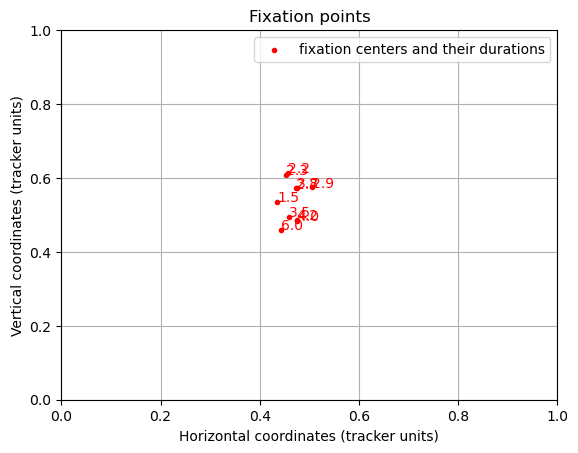

Fixation Rate Test 1: 0.23847812892615108 fixations/s
Fixation_ID [X_coord, Y_coord, Duration, Start_time, End_time, No_gaze_points]
1 [0.4805181908131031, 0.5512258504250949, 2.9439159999601543, 0.0037589999847114086, 2.9476749999448657, 721]
2 [0.490417117623525, 0.572574216580353, 1.4838844999903813, 3.2078700000420213, 4.691754500032403, 320]
3 [0.4864863541447261, 0.43224694100400307, 2.683767499984242, 4.700024500023574, 7.383792000007816, 614]
4 [0.49067510150280486, 0.567811526810482, 1.1821375000290573, 7.391676499973983, 8.57381400000304, 294]
5 [0.45617343259555226, 0.4671375466462697, 3.1213814999209717, 8.582456000032835, 11.703837499953806, 733]
6 [0.47650534132587496, 0.4767980510373969, 5.354195500025526, 12.583798000006936, 17.937993500032462, 1272]
7 [0.4757884351901469, 0.5674814493131122, 2.3578240000642836, 17.94599749997724, 20.303821500041522, 577]


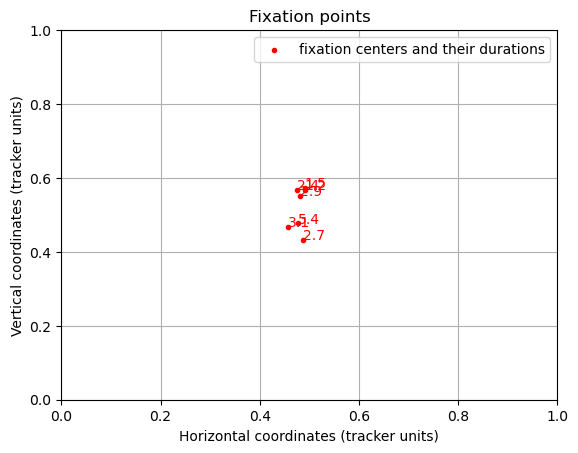

Fixation Rate Test 2: 0.30716490891923476 fixations/s
Fixation_ID [X_coord, Y_coord, Duration, Start_time, End_time, No_gaze_points]
1 [0.4652245863740432, 0.5325524832360303, 5.3833894999697804, 2.907365999999456, 8.290755499969237, 1165]
2 [0.4784062000851027, 0.5488294902203257, 2.5984044999349862, 8.591474000015296, 11.189878499950282, 595]
3 [0.4683095888183844, 0.523262675950351, 3.309404000057839, 19.61526899994351, 22.92467300000135, 690]
4 [0.42857599254641443, 0.5135831879812808, 1.0476120000239462, 23.65994799998589, 24.707560000009835, 260]
5 [0.5305069326671227, 0.5762896347628492, 2.9800089999334887, 24.863289000000805, 27.843297999934293, 728]
6 [0.46283411061202767, 0.522843536964197, 4.839087500004098, 27.85134549997747, 32.69043299998157, 1194]
7 [0.442540882008287, 0.6102020016812068, 1.1406000000424683, 33.58667599991895, 34.72727599996142, 239]
8 [0.4896507918066903, 0.5904030190737508, 3.1324680000543594, 34.839351999922656, 37.971819999977015, 737]
9 [0.495095676

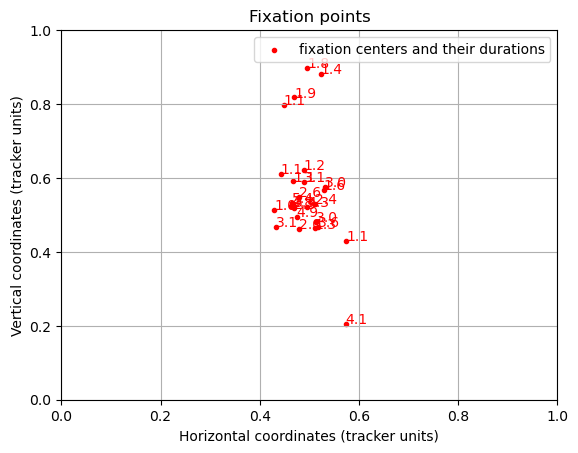

Fixation Rate Test 3: 0.28784175098201326 fixations/s
Fixation_ID [X_coord, Y_coord, Duration, Start_time, End_time, No_gaze_points]
1 [0.4854960613934531, 0.4922654095079318, 5.558824999956414, 0.0, 5.558824999956414, 1133]
2 [0.450126114892197, 0.40556837432757653, 2.3122930000536144, 5.994756000000052, 8.307049000053667, 572]
3 [0.45680446640252326, 0.5076419720039026, 2.8227140000090003, 9.410200500045903, 12.232914500054903, 399]
4 [0.4924478893430991, 0.46992610413998714, 4.092635000008158, 12.945167499943636, 17.037802499951795, 955]
5 [0.4790211045981511, 0.5468239713684178, 1.4256125000538304, 18.231224999995902, 19.656837500049733, 180]
6 [0.45924756682862566, 0.4111206631233899, 1.073145000031218, 19.978865499957465, 21.052010499988683, 260]
7 [0.4932418553246271, 0.39878429177884644, 1.2237929999828339, 22.264705499983393, 23.488498499966227, 298]
8 [0.4840895519905814, 0.49345968922465305, 1.2598879999713972, 23.640745499986224, 24.90063349995762, 308]
9 [0.496349349589119

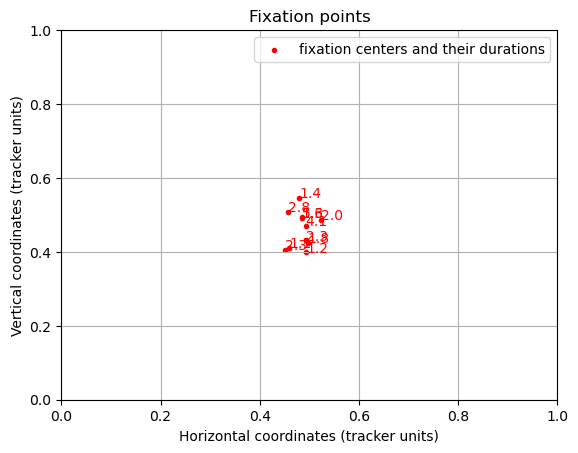

Fixation Rate Test 4: 0.3218160018468735 fixations/s


In [20]:
current_participant = 46
gaze_test1 = participant_tests[current_participant][3][3][0]

#pygazeanalyser.detectors.fixation_detection(gaze_test1['norm_pos_x'], gaze_test1['norm_pos_y'], gaze_test1['gaze_timestamp'], maxdist=2.5)

# create a gazelist in following order: norm_pos_x, norm_pos_y, gaze_timestamp
gaze_data = gaze_test1[['norm_pos_x', 'norm_pos_y', 'gaze_timestamp']].values.tolist()

result = peyemmv.extract_fixations_list(gaze_data, 0.1, 0.1, 1, '0')

# calculate the fixationrate for each test. the unit of the timestamp is seconds
for i in range(4):
    participant_test = participant_tests[current_participant][i]
    participant_test_gaze = participant_test[3][0]
    gaze_data = participant_test_gaze[['norm_pos_x', 'norm_pos_y', 'gaze_timestamp']].values.tolist()
    result = peyemmv.extract_fixations_list(gaze_data, 0.1, 0.1, 1, '1')
    print("Fixation Rate Test " + str(i+1) + ": " + str(len(result)/participant_test_gaze['gaze_timestamp'].iloc[-1]) + " fixations/s")
    
    

In [21]:
# checking preprocessed_df 
preprocessed_df.head()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate
0,1,1,33.64395,10,5,15,25,25,10,15,43.855534,43.893976,0.059446,0.295946
1,1,2,28.484322,50,30,25,50,15,25,32.5,42.935538,43.021599,NaN,0.175533
2,1,3,71.423823,100,10,75,80,90,20,62.5,44.704459,44.791630,0.196013,0.196018
3,1,4,38.163442,60,15,45,50,20,25,35.8,45.762156,45.845470,0.052406,0.288263
4,2,1,41.748047,20,10,20,10,20,15,15.8,31.492393,31.393101,0.047906,0.143727


In [22]:
preprocessed_df.describe()

,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate
count,188.000000,188.000000,149.000000,188.000000
mean,34.841518,34.738427,0.203396,0.276538
std,5.269522,5.195801,0.192142,0.067758
min,25.644326,25.583751,0.001379,0.000000
25%,31.054235,31.085921,0.056837,0.232809
50%,33.783967,33.724105,0.138792,0.277894
75%,37.903275,37.631562,0.299094,0.322440
max,50.119098,50.139223,0.947007,0.552124


In [23]:
file_name = 'preprocessed_df.csv'
file_path = os.path.join(data_path, file_name)

# only save if file does not exist
if not os.path.exists(file_path):
    preprocessed_df.to_csv(file_path, index=False, header=True, encoding='utf-8')
    print('Successfully saved preprocessed_df.csv')
else:
    print('File already exists. Skipping export of preprocessed_df.csv')

Successfully saved preprocessed_df.csv


# Calculating relative changes to baseline

Relevant features:
- `mean_pupil_diameter`
- `median_pupil_diameter`
- `blinkrate`
- `fixationrate`

Above mentioned features are quite individual for the participiants. The first test will act as the baseline, since it is the 'easiest' test to perform (i.e. no time constraints and no secondary tasks). With these additional features we can see easier how the difficulty of the tasks affect the pupil diameter, blink rate and fixation rate. 

In [24]:
# load the dataset
file_name = 'preprocessed_df.csv'
file_path = os.path.join(data_path, file_name)
og_df = pd.read_csv(file_path)
og_df.head()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate
0,1,1,33.643950,10,5,15,25,25,10,15.0,43.855534,43.893976,0.059446,0.295946
1,1,2,28.484322,50,30,25,50,15,25,32.5,42.935538,43.021599,NaN,0.175533
2,1,3,71.423823,100,10,75,80,90,20,62.5,44.704459,44.791630,0.196013,0.196018
3,1,4,38.163442,60,15,45,50,20,25,35.8,45.762156,45.845470,0.052406,0.288263
4,2,1,41.748047,20,10,20,10,20,15,15.8,31.492393,31.393101,0.047906,0.143727


In [25]:
# replace blinkrate NaN with 0
selected_rows = ['participant_id','test_id','blinkrate']
print(og_df[selected_rows].head())

print('--------------------------')

og_df['blinkrate'] = og_df['blinkrate'].fillna(0)
print(og_df[selected_rows].head())

   participant_id  test_id  blinkrate
0               1        1   0.059446
1               1        2        NaN
2               1        3   0.196013
3               1        4   0.052406
4               2        1   0.047906
--------------------------
   participant_id  test_id  blinkrate
0               1        1   0.059446
1               1        2   0.000000
2               1        3   0.196013
3               1        4   0.052406
4               2        1   0.047906


In [26]:

# add baseline data for further calculations
baseline_df = og_df[og_df['test_id'] == 1]
baseline_df = baseline_df.set_index('participant_id')[['blinkrate', 'fixationrate', 'mean_pupil_diameter', 'median_pupil_diameter']]
baseline_df.columns = [f'{col}_bl' for col in baseline_df.columns]
baseline_df.head()

,blinkrate_bl,fixationrate_bl,mean_pupil_diameter_bl,median_pupil_diameter_bl
participant_id,,,,
1,0.059446,0.295946,43.855534,43.893976
2,0.047906,0.143727,31.492393,31.393101
3,0.141675,0.259758,31.121870,30.685299
4,0.055205,0.220767,30.325795,30.422947
5,0.000000,0.345514,31.569808,31.538508


In [27]:
# merge baseline back into original dataframe
og_df = og_df.join(baseline_df, on='participant_id')
og_df.head()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,blinkrate_bl,fixationrate_bl,mean_pupil_diameter_bl,median_pupil_diameter_bl
0,1,1,33.643950,10,5,15,25,25,10,15.0,43.855534,43.893976,0.059446,0.295946,0.059446,0.295946,43.855534,43.893976
1,1,2,28.484322,50,30,25,50,15,25,32.5,42.935538,43.021599,0.000000,0.175533,0.059446,0.295946,43.855534,43.893976
2,1,3,71.423823,100,10,75,80,90,20,62.5,44.704459,44.791630,0.196013,0.196018,0.059446,0.295946,43.855534,43.893976
3,1,4,38.163442,60,15,45,50,20,25,35.8,45.762156,45.845470,0.052406,0.288263,0.059446,0.295946,43.855534,43.893976
4,2,1,41.748047,20,10,20,10,20,15,15.8,31.492393,31.393101,0.047906,0.143727,0.047906,0.143727,31.492393,31.393101


In [28]:
# calculate relative changes to baseline for each participant and test
metrics = ['blinkrate', 'fixationrate', 'mean_pupil_diameter', 'median_pupil_diameter']
for metric in metrics:
    og_df[f'{metric}_rel'] = og_df[metric] - og_df[f'{metric}_bl']

    # calculate percentage change where baseline is not zero, set to NaN where baseline is zero
    og_df[f'{metric}_rel_pct'] = np.where(og_df[f'{metric}_bl'] != 0,
                                       (og_df[f'{metric}_rel'] / og_df[f'{metric}_bl']) * 100,
                                       np.nan)

og_df.head()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,...,mean_pupil_diameter_bl,median_pupil_diameter_bl,blinkrate_rel,blinkrate_rel_pct,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct
0,1,1,33.643950,10,5,15,25,25,10,15.0,...,43.855534,43.893976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,28.484322,50,30,25,50,15,25,32.5,...,43.855534,43.893976,-0.059446,-100.000000,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465
2,1,3,71.423823,100,10,75,80,90,20,62.5,...,43.855534,43.893976,0.136567,229.732630,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050
3,1,4,38.163442,60,15,45,50,20,25,35.8,...,43.855534,43.893976,-0.007040,-11.842464,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927
4,2,1,41.748047,20,10,20,10,20,15,15.8,...,31.492393,31.393101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
# drop baseline from dataset
columns_to_drop = [f'{metric}_bl' for metric in metrics]
og_df.drop(columns=columns_to_drop, inplace=True)

# check columns
print(og_df.columns)

Index(['participant_id', 'test_id', 'test_duration', 'mental', 'physical',
       'temporal', 'performance', 'effort', 'frustration', 'mean',
       'mean_pupil_diameter', 'median_pupil_diameter', 'blinkrate',
       'fixationrate', 'blinkrate_rel', 'blinkrate_rel_pct',
       'fixationrate_rel', 'fixationrate_rel_pct', 'mean_pupil_diameter_rel',
       'mean_pupil_diameter_rel_pct', 'median_pupil_diameter_rel',
       'median_pupil_diameter_rel_pct'],
      dtype='object')


In [30]:
# save new preprocessed dataset as a csv file 
file_name = 'preprocessed_df_v2.csv'
file_path = os.path.join(data_path, file_name)

# only save if file does not exist
if not os.path.exists(file_path):
    og_df.to_csv(file_path, index=False, header=True, encoding='utf-8')
    print('Successfully exported preprocessed_df_v2.csv')
else:
    print('File already exists. Skipping export of preprocessed_df_v2.csv')

Successfully exported preprocessed_df_v2.csv


## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [31]:

# Load the data
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv(file_path)

# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head())



Number of samples: 188
Number of features: 22
Example data:
   participant_id  test_id  test_duration  mental  physical  temporal  \
0               1        1      33.643950      10         5        15   
1               1        2      28.484322      50        30        25   
2               1        3      71.423823     100        10        75   
3               1        4      38.163442      60        15        45   
4               2        1      41.748047      20        10        20   

   performance  effort  frustration  mean  ...  blinkrate  fixationrate  \
0           25      25           10  15.0  ...   0.059446      0.295946   
1           50      15           25  32.5  ...   0.000000      0.175533   
2           80      90           20  62.5  ...   0.196013      0.196018   
3           50      20           25  35.8  ...   0.052406      0.288263   
4           10      20           15  15.8  ...   0.047906      0.143727   

   blinkrate_rel  blinkrate_rel_pct  fixationrate_

## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [32]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values


participant_id                    0
test_id                           0
test_duration                     0
mental                            0
physical                          0
temporal                          0
performance                       0
effort                            0
frustration                       0
mean                              0
mean_pupil_diameter               0
median_pupil_diameter             0
blinkrate                         0
fixationrate                      0
blinkrate_rel                     0
blinkrate_rel_pct                48
fixationrate_rel                  0
fixationrate_rel_pct              0
mean_pupil_diameter_rel           0
mean_pupil_diameter_rel_pct       0
median_pupil_diameter_rel         0
median_pupil_diameter_rel_pct     0
dtype: int64

In [33]:
# Handling missing values
# Example: Replacing NaN values with the mean value of the column
# df.fillna(df.mean(), inplace=True)

# Your code for handling missing values goes here


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


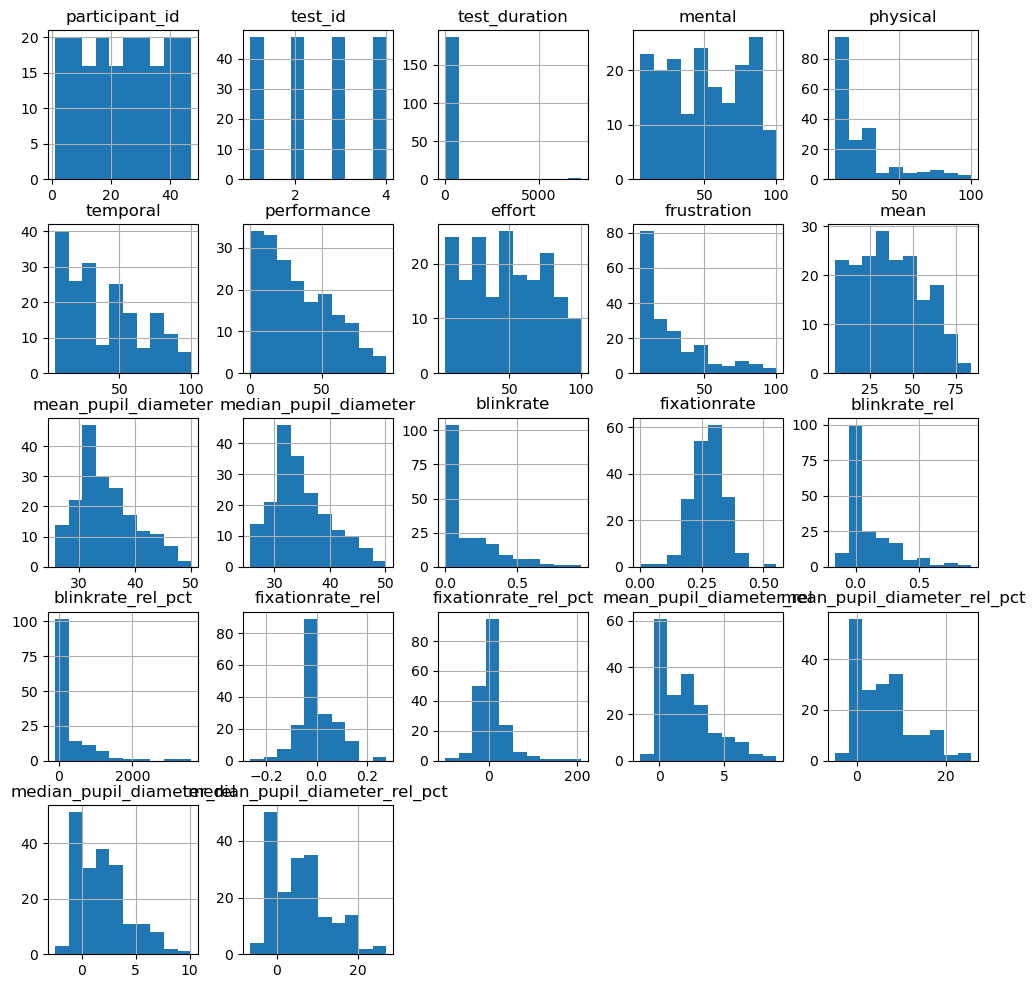

In [34]:
# Example: Plotting histograms of all numerical features
df.hist(figsize=(12, 12))
plt.show()


## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [35]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


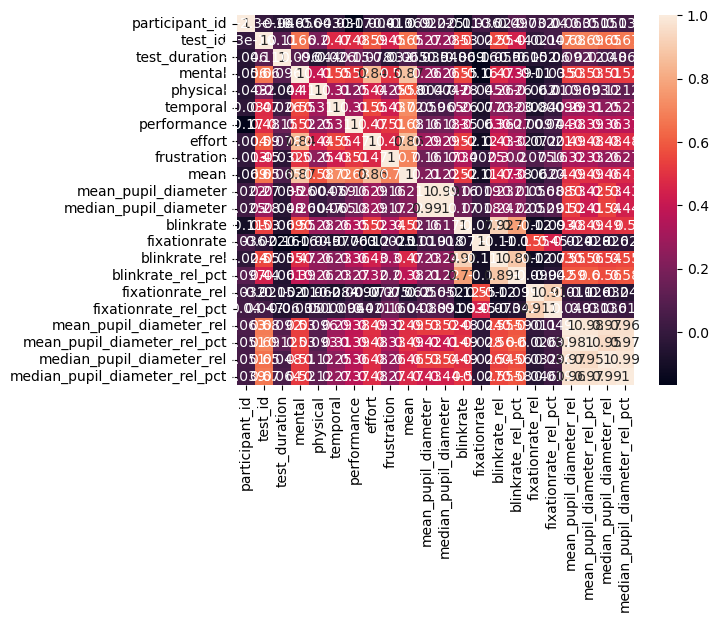

In [36]:
# Example: Plotting a heatmap to show feature correlations
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()
